<a href="https://colab.research.google.com/github/abrar39/abrar39/blob/master/Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [23]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-qmd4u05e
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-qmd4u05e
  Resolved https://github.com/albumentations-team/albumentations to commit 30deec1ee4f3bf8e56c43baa894de970e609852b
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [24]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


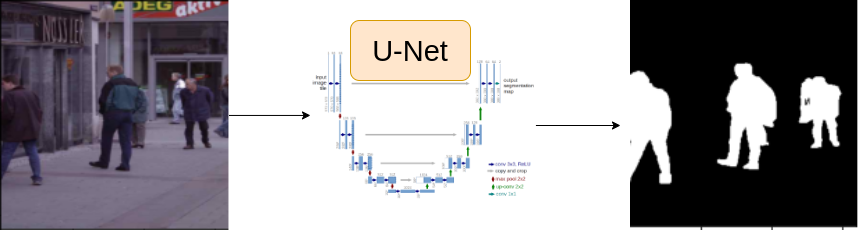

# Some Common Imports

In [25]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [26]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

In [103]:
torch.__version__

'2.0.1+cu118'

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content'

DEVICE = 'cuda'
EPOCHS = 25
LR = 0.001
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [28]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [29]:
# display random sample data using the dataframe of paths

idx = np.random.choice(len(df), replace=False)
row = df.iloc[idx]
image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path) #bgr image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to rgb image

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255. #grayscale 

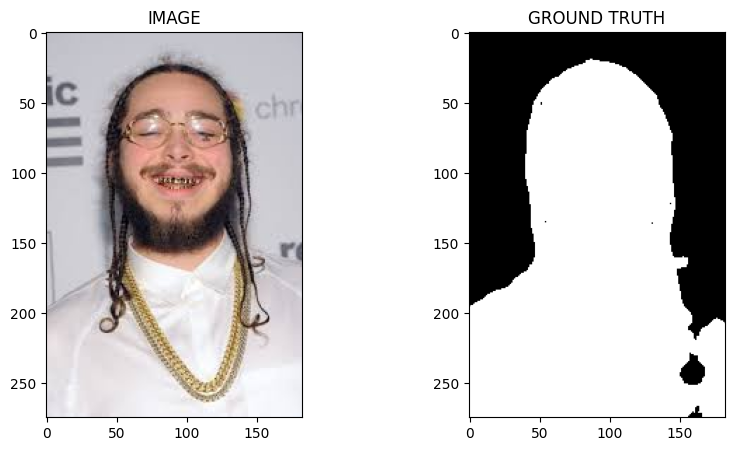

In [30]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [31]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42) #using scikitlear

In [32]:
# augmentations are applied on both the image and the ground truth in segmentation datasets
import albumentations as A


In [40]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE), #resize the image
      A.HorizontalFlip(p=0.5), #random horizontal flip
      A.VerticalFlip(p=0.5) #random vertical flip
  ], is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),  #resize the image
  ], is_check_shapes=False)

# Task 4 : Create Custom Dataset 

In [34]:
from torch.utils.data import Dataset

In [65]:
train_df.columns

Index(['masks', 'images'], dtype='object')

In [69]:
train_df.iloc[1]['images']

'Human-Segmentation-Dataset-master/Training_Images/288.jpg'

In [70]:
class SegmentationDataset(Dataset):
  """
  Implementation of a custom dataset
  """
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    images_path = row['images']
    masks_path = row['masks']

    image = cv2.imread(images_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(masks_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis=-1) #add the channel dimension

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image = data['image']
      mask = data['mask']

    #pytorch uses (c, h, w) so we shall convert to it
    image = np.transpose(image, (2, 0, 1)).astype(np.float32) #(h, w, c) > (c, h, w)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    #from numpy to tensor
    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask


In [71]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [72]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


In [73]:
def show_image_and_mask(idx, dataset):
  image, mask = dataset[idx]

  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
  ax1.set_title('IMAGE')
  ax1.imshow(np.transpose(image, (1, 2, 0)))

  ax2.set_title('GROUND TRUTH')
  ax2.imshow(np.transpose(mask, (1, 2, 0)),cmap = 'gray')

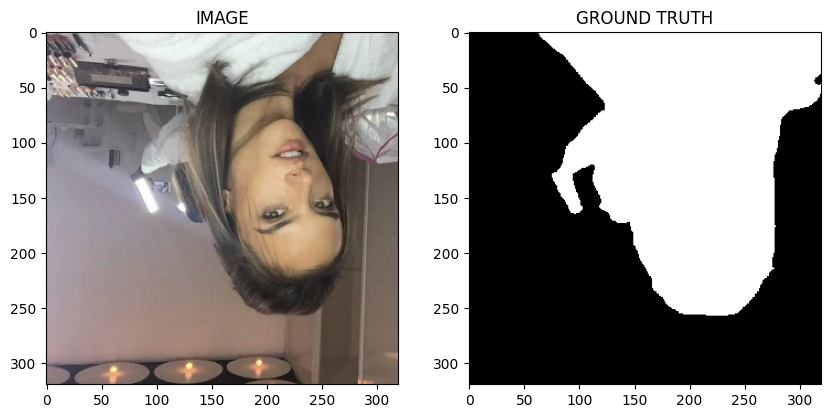

In [74]:
show_image_and_mask(1, trainset)

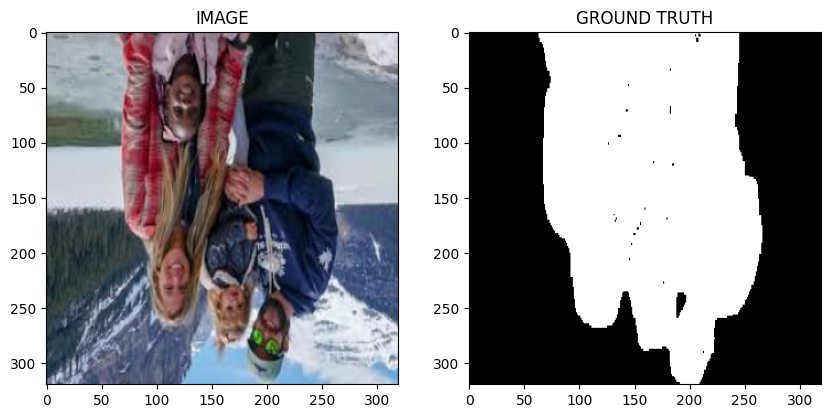

In [75]:
show_image_and_mask(2, trainset)

# Task 5 : Load dataset into batches

In [76]:
from torch.utils.data import DataLoader

In [77]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [78]:
# total number of batches
print(f'total number of batches in trainloader : {len(trainloader)}')
print(f'total number of batches in validloader : {len(validloader)}')

total number of batches in trainloader : 15
total number of batches in validloader : 4


In [79]:
for image, mask in trainloader:
  break

print(f'One batch image shape : {image.shape}')
print(f'One batch mask shape : {mask.shape}')

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [80]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [90]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()
    # the architechture
    self.arc = smp.Unet(
        encoder_name = ENCODER, 
        encoder_weights = WEIGHTS, 
        in_channels = 3, 
        classes = 1, 
        activation = None # return logits
    )

  def forward(self, images, masks=None):
    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)

      return logits, loss1 + loss2

    return logits

In [91]:
model = SegmentationModel().to(DEVICE)

In [84]:
model

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function 

In [85]:
def train_fn(dataloader, model, optimizer):
  model.train() #set to training mode
  total_loss = 0 #initialize
  for images, masks in dataloader:
    # move images and masks to cuda
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

  optimizer.zero_grad()
  logits, loss = model(images, masks)
  loss.backward()
  optimizer.step()
  
  total_loss += loss.item()

  return total_loss / len(dataloader)

In [86]:
def eval_fn(dataloader, model):
  model.eval() #set to training mode
  total_loss = 0 #initialize

  with torch.no_grad(): #no gradients during evaluation
    for images, masks in dataloader:
      # move images and masks to cuda
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)
    
    logits, loss = model(images, masks)
    
    total_loss += loss.item()

  return total_loss / len(dataloader)

# Task 8 : Train Model

In [104]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = ReduceLROnPlateau(optimizer, mode='min', )

In [105]:
# the training loop
def train(epochs=EPOCHS):
  best_valid_loss = np.Inf

  for i in np.arange(epochs):
    train_loss = train_fn(trainloader, model, optimizer)
    valid_loss = eval_fn(validloader, model)
    scheduler.step(valid_loss)

    # save the model if improved
    if valid_loss < best_valid_loss:
      torch.save(model.state_dict(), 'best_model.pt')
      print('Model SAVED!!')
      best_valid_loss = valid_loss

    print(f'Epoch : {i+1}, Train Loss : {train_loss}, Validation Loss : {valid_loss}')

In [106]:
train(100)

Model SAVED!!
Epoch : 1, Train Loss : 0.013583487272262574, Validation Loss : 0.06113326922059059
Epoch : 2, Train Loss : 0.009252744913101196, Validation Loss : 0.0747951939702034
Epoch : 3, Train Loss : 0.026762562990188598, Validation Loss : 0.11540808528661728
Epoch : 4, Train Loss : 0.018999928236007692, Validation Loss : 0.11550074070692062
Epoch : 5, Train Loss : 0.014918132623036703, Validation Loss : 0.12303567677736282
Epoch : 6, Train Loss : 0.0227793554464976, Validation Loss : 0.11540652066469193
Epoch : 7, Train Loss : 0.021343145767847696, Validation Loss : 0.1058223769068718
Epoch : 8, Train Loss : 0.013865850369135539, Validation Loss : 0.10765890777111053
Epoch : 9, Train Loss : 0.033226986726125084, Validation Loss : 0.10220528393983841
Epoch : 10, Train Loss : 0.02156753142674764, Validation Loss : 0.10323341190814972
Epoch : 11, Train Loss : 0.011810400088628133, Validation Loss : 0.10564037412405014
Epoch : 12, Train Loss : 0.017970148722330728, Validation Loss : 

# Task 9 : Inference

In [107]:
idx = 20

model.load_state_dict(torch.load('/content/best_model.pt'))
image, mask = validset[idx]
logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(C, H, W) > (1, C, H, W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

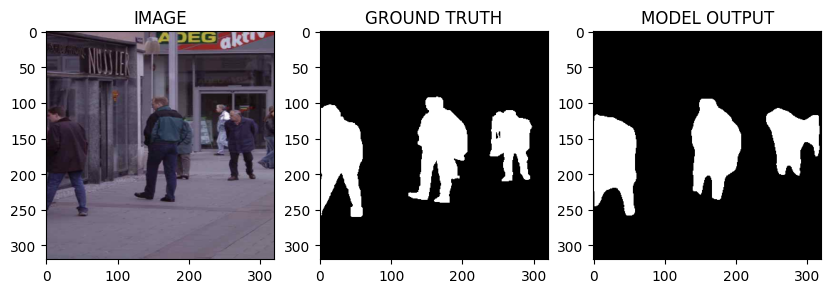

In [108]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))